In [1]:
import platform 
import os, time
# dictionary 
info = {} 
  
platform_details = platform.platform() 
info["platform details"] = platform_details 
system_name = platform.system() 
info["system name"] = system_name 
processor_name = platform.processor() 
info["processor name"] = processor_name 
architecture_details = platform.architecture() 
info["architectural detail"] = architecture_details 
for i, j in info.items(): 
    print(i, " - ", j) 
print(time.strftime('%X'))
print(os.getcwd())

platform details  -  Windows-10-10.0.19041-SP0
system name  -  Windows
processor name  -  Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
architectural detail  -  ('64bit', 'WindowsPE')
17:01:38
C:\Users\sd\notebooks\MAIN_PRJWindows\AddConstToObj


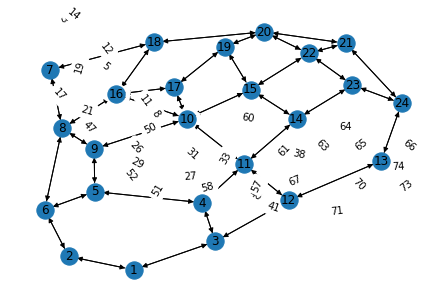

C:\Users\sd\anaconda3\envs\py38\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [2]:
import networkx as nx
import sqlite3 
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sdNetworkUtility  import *
from sdTapPyomo  import *
from sdLIPSolverAddConstToObj  import *
#----------------------------------
#در ساختار شبکه در جدول نودها فرض شده که نودهایی که می توانند مبدا یا مقصد یک زوج مبدا مقصد باشند(زون هستند)در همان ابندای جدول و از اندیس
#1 - n
#آمده اند و فیلد 
#is_OD 
#آنها 1 است
np. set_printoptions(threshold=np. inf)

# Create a SQL connection to our SQLite database               # 9Nodes  SiouxFalls Anaheim
con = sqlite3.connect("C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/1_project/SiouxFalls/project_database.sqlite")
cur = con.cursor()
G = nx.DiGraph()
#مشخص کردن تعداد ODها
cur.execute('SELECT count(is_OD) FROM nodes where is_OD = 1 ')
Data= cur.fetchall()
NodeODCount =Data[0][0] #تعداد نودهایی که مبدا یا مقصد هستند(زون هستند) 
ODCount = NodeODCount**2
#-------------
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data: #---We use free_flow_time As weight of edges for compute K-Shortest path
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
#----------رسم گراف شبکه----

sdDrawGraph(nx,G)

ODNumber_Matrix = sdGet_ODNumber_Matrix(NodeODCount)
n,m = np.shape(ODNumber_Matrix)

# تقاضا بین زوجها
ODDeman_Matrix = pd.read_excel(r'C:/Users/sd/notebooks/MAIN_PRJWindows/TraficAssignment/0_tntp_data/SiouxFalls/xod.xlsx',sheet_name='Sheet1')
ODDeman_Vector = np.zeros(ODCount) 
for i in range(n):
     for j in range(m):
        ODDeman_Vector[ODNumber_Matrix[i,j] - 1] = ODDeman_Matrix.iloc[i,j]

#--تعریف ساختمان داده های لازم
#لیست تمام یالهای گراف را میدهد اما نامرتب
edgs = list(G.edges(data=True))

#مرتب کردن یالها بر اساس شماره لینک
LinksList =  list(np.zeros(len(edgs)))
for row in edgs:
    LinksList[row[2]['link_id'] -1] = row
 
 
#فقط برای نودهای مبدا-مقصد که در اول لیست نودها هم هستند 3 کوتاهترین مسیرها محاسبه می شود
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)

        #ماتریس تعیین عضویت هر زوج در هر مسیر
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

#P_i: set of paths between origin-destination in I
LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        



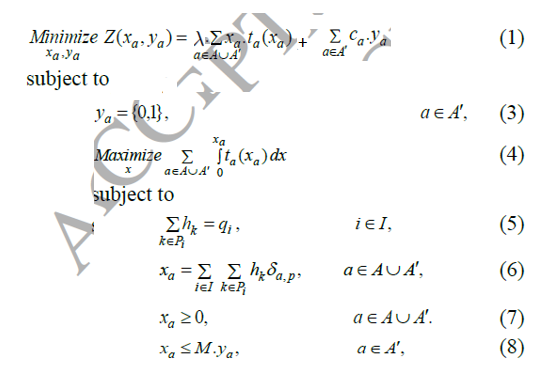

In [3]:
#--Calculate High Level Objective Function
# free Flow Time به دقیقه
#زمان سفر کل بر حسب دقیقه در روز
#ظرفیت  بر حسب تعداد خودرو در روز
#جریان  بر حسب تعداد خودرو در روز
# تعداد خودرو در روز تقاضای سفر بر حسب

def CalcZ(intObjectiveFunc,X,Capacity,Tzero,Cost,linksY, Min1=0,Max1=0,Min2 = 0,Max2=0, Landa= 1):
    #ایران
    #GDP = 2282 * 280000  #ریال
    #TW = 365 * 8
    #VOT = GDP / TW  ارزش یک ساعت کار
   #------------------
    #آمریکا
    GDP = 63543  #دلار
    TW = 365 * 5 # 
    VOT = GDP / TW  #  ارزش یک ساعت کار
    VOT = VOT / 60 #ارزش یک دقیقه کار
    if intObjectiveFunc == 1: #فقط زمان سفر کل
        return sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) )
    elif intObjectiveFunc == 2: #فقط هزینه ساخت
        return sum(Cost[z] * linksY[z] for z in range(len(Cost)))
    elif intObjectiveFunc == 3: #  در رنج 1 هر دو
        C1 = Max1 - Min1
        C2 = Max2 - Min2
        return ( Landa * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) - Min1) /C1)  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) - Min2) / C2) )  
    elif intObjectiveFunc == 4: # هر دو
        return ( Landa * VOT * (((sum(X[k] * (Tzero[k]*(1 + 0.15 * pow( (X[k] / Capacity[k]),4) ) ) for k in range(len(X)) ) ) ))  + ( (sum(Cost[z] * linksY[z] for z in range(len(Cost))) ) ) )  
    

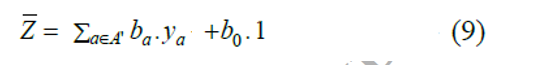

Satrt Time: 17:01:55


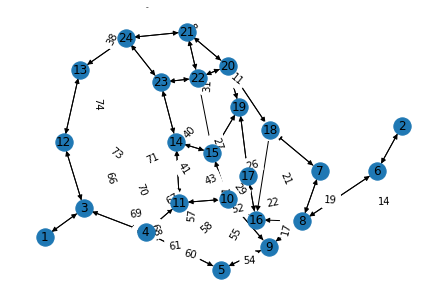

In [4]:
print('Satrt Time: '+time.strftime('%X'))

Landa =5

#Anaheim
#NewLinkIds = np.array([636,719, 771,718 ,665,699, 414,451, 428,483])
#NewLinkCost = np.array([44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9,44 * 10**9, 59 * 10**9, 79 * 10**9, 86 * 10**9, 58 * 10**9])

#SiouxFalls
NewLinkIds = np.array([1,3, 12,15 ,33,36, 47,46, 50])#,55])
NewLinkCost = np.array([2.4 * 10**6, 2.4 * 10**6, 2.1 * 10**6, 2.1 * 10**6, 2.2 * 10**6,2.2 * 10**6, 1.9 * 10**6, 1.9 * 10**6, 1.8 * 10**6])#, 1.8 * 10**6])


#9Nodes
#NewLinkIds = np.array([4,6,9,12,14,20]) 
#NewLinkCost = np.array([8 * 10**3, 1.8 * 10**3,9 * 10**3,7 * 10**3,6 * 10**3,10 * 10**3])


#حذف لینکهای جدید از شبکه برای آماده کردن شبکه
strLinksForRemove = '-1'
for lkid in NewLinkIds:
    strLinksForRemove = strLinksForRemove + ',' + str(lkid)
#---دور اول ---
y =  np.array([[0] * len(NewLinkIds)])#انداره y  لینکهای جدید به تعداد

    
# ساخت مجدد شبکه و اطلاعات لازم
cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
Data= cur.fetchall()
G.clear()
for row in Data:
    G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
LinksList = list(G.edges(data=True))
All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
        #ماتریس تعیین عضویت هر لینک در هر مسیر
DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)


LinkCount = len(LinksList) 
PathCount = len(All_KshortestPathList )
#total flow on the path k in P_ij = _fijk         جریان در کاامین مسیر از زوج آی و جی

LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
#-------------------------------
sdDrawGraph(nx,G)

flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
#print('flows',flows)

#Maximum of TotalTravelTime Occured when all y are 0
#MaxTotalTravelTime = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 
#MinCostForNewLinks = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])]) 

#print('y = ', y[0][:len(y[0])])
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)

#---Calculate z base on flows---
z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],
          0,0,0,0, Landa)

#print('z',z)
# ---Adding Curent z To Z vector---
Z = np.array( [z])
#print('Z',Z)

Y= np.array(y)


In [5]:


#---حلقه اصلی برنامه----
print('Satrt Time: '+time.strftime('%X'))
TedadTekrar = pow(2,len(NewLinkIds))
for Idx in range(TedadTekrar):#Main Loop
        print("شماره تکرار:  ",Idx)
        StrBinIdx =  str(bin(Idx))[::-1]
        y =  [int(d) for d in StrBinIdx[:len(StrBinIdx)-2]]
        y = y[:len(NewLinkIds)] + [0]*(len(NewLinkIds) - len(y)) 
        y = [y]
        print("y:  ",y)
    #---Create Network Base  On current y---
        strLinksForRemove = '-1'
        for i in range(len(y[0])):
            if y[0][i] == 0:
                strLinksForRemove = strLinksForRemove + ',' + str(NewLinkIds[i])
                
        #DrawNetwork(prj)
       #---ساخت مجدد شبکه با اعمال تغییرات لینکها 
        cur.execute('SELECT a_node,b_node,link_id,capacity_ab,free_flow_time FROM links where link_id not in ('+ strLinksForRemove + ' ) order by link_id ')
        Data= cur.fetchall()
        G.clear()
        for row in Data:
            G.add_edge(row[0], row[1],weight=row[4],link_id=row[2],capacity_ab=row[3],free_flow_time=row[4])
        LinksList = list(G.edges(data=True))
        All_KshortestPathList = sdGetAll_KshortestPath(nx,G,3,NodeODCount)
        DeltaOD_Matrix = sdGet_DeltaOD_Matrix(G,ODNumber_Matrix,All_KshortestPathList,ODCount) 
                #ماتریس تعیین عضویت هر لینک در هر مسیر
        DeltaLink_Matrix = sdGet_DeltaLink_Matrix(G,LinksList,All_KshortestPathList)

        #P_i: set of paths between origin-destination in I
        LinkCount = len(LinksList) 
        PathCount = len(All_KshortestPathList )
       

        LinkCap_Vector = [ row[2]['capacity_ab'] for row in LinksList]

        LinkFreeFlowTime_Vector = [ row[2]['free_flow_time'] for row in LinksList]
        #-------------------------------
        
        #---Solve TAP and calculate flows---
        flows = sdSolveTapByPyomo(PathCount,LinkCount,ODCount,DeltaOD_Matrix,DeltaLink_Matrix,ODDeman_Vector,LinkFreeFlowTime_Vector,LinkCap_Vector)
        #print('flows',flows)
        #---Calculate z base on flows---
        #z1 = CalcZ(1,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #z2 = CalcZ(2,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])])
        #print("z1 = ",z1)
        #print("z2 = ",z2)

       
        z = CalcZ(4,flows,LinkCap_Vector,LinkFreeFlowTime_Vector,NewLinkCost,y[0][:len(y[0])],
          0,0,0,0, Landa)
        print("z = ",z)

        # ---Adding Curent z To Z vector---
        Z = np.append(Z,[z], axis = 0) 

        #========REGRESSION===========
        Y= np.append(Y, y, axis = 0)
    
print('********************************************')
print('********************************************')
#print('MinTotalTravelTime = ', MinTotalTravelTime)
#print('MaxTotalTravelTime = ', MaxTotalTravelTime)
#print('MinCostForNewLinks = ', MinCostForNewLinks)
#print('MaxCostForNewLinks = ', MaxCostForNewLinks)



print('Min Of Z = ',np.amin(Z), '  Where is in  ',np.where(Z == np.amin(Z)))
 
print('Max Of Z = ',np.amax(Z), '  Where is in  ',np.where(Z == np.amax(Z)))

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)

print('Finish Time: '+time.strftime('%X'))


Satrt Time: 17:02:30
شماره تکرار:   0
y:   [[0, 0, 0, 0, 0, 0, 0, 0, 0]]
z =  156707023.2504523
شماره تکرار:   1
y:   [[1, 0, 0, 0, 0, 0, 0, 0, 0]]
z =  137427187.60901296
شماره تکرار:   2
y:   [[0, 1, 0, 0, 0, 0, 0, 0, 0]]
z =  162461733.53559855
شماره تکرار:   3
y:   [[1, 1, 0, 0, 0, 0, 0, 0, 0]]
z =  138720212.05262154
شماره تکرار:   4
y:   [[0, 0, 1, 0, 0, 0, 0, 0, 0]]
z =  120136288.56862497
شماره تکرار:   5
y:   [[1, 0, 1, 0, 0, 0, 0, 0, 0]]
z =  130111708.5278108
شماره تکرار:   6
y:   [[0, 1, 1, 0, 0, 0, 0, 0, 0]]
z =  122090569.9712253
شماره تکرار:   7
y:   [[1, 1, 1, 0, 0, 0, 0, 0, 0]]
z =  129691564.5728069
شماره تکرار:   8
y:   [[0, 0, 0, 1, 0, 0, 0, 0, 0]]
z =  152160918.2944457
شماره تکرار:   9
y:   [[1, 0, 0, 1, 0, 0, 0, 0, 0]]
z =  129818264.17074893
شماره تکرار:   10
y:   [[0, 1, 0, 1, 0, 0, 0, 0, 0]]
z =  161123407.35699427
شماره تکرار:   11
y:   [[1, 1, 0, 1, 0, 0, 0, 0, 0]]
z =  136145506.79909623
شماره تکرار:   12
y:   [[0, 0, 1, 1, 0, 0, 0, 0, 0]]
z =  109214335.23

z =  109538007.13333525
شماره تکرار:   108
y:   [[0, 0, 1, 1, 0, 1, 1, 0, 0]]
z =  87667007.15720941
شماره تکرار:   109
y:   [[1, 0, 1, 1, 0, 1, 1, 0, 0]]
z =  99677407.74849072
شماره تکرار:   110
y:   [[0, 1, 1, 1, 0, 1, 1, 0, 0]]
z =  97803709.29813942
شماره تکرار:   111
y:   [[1, 1, 1, 1, 0, 1, 1, 0, 0]]
z =  107993272.39966051
شماره تکرار:   112
y:   [[0, 0, 0, 0, 1, 1, 1, 0, 0]]
z =  93798476.26448704
شماره تکرار:   113
y:   [[1, 0, 0, 0, 1, 1, 1, 0, 0]]
z =  101463493.14912882
شماره تکرار:   114
y:   [[0, 1, 0, 0, 1, 1, 1, 0, 0]]
z =  99240494.08729838
شماره تکرار:   115
y:   [[1, 1, 0, 0, 1, 1, 1, 0, 0]]
z =  104789683.43089913
شماره تکرار:   116
y:   [[0, 0, 1, 0, 1, 1, 1, 0, 0]]
z =  88311719.0421249
شماره تکرار:   117
y:   [[1, 0, 1, 0, 1, 1, 1, 0, 0]]
z =  102205781.0749936
شماره تکرار:   118
y:   [[0, 1, 1, 0, 1, 1, 1, 0, 0]]
z =  93027866.40058932
شماره تکرار:   119
y:   [[1, 1, 1, 0, 1, 1, 1, 0, 0]]
z =  104976922.10933867
شماره تکرار:   120
y:   [[0, 0, 0, 1, 1, 1, 1, 0,

z =  72452008.68726042
شماره تکرار:   215
y:   [[1, 1, 1, 0, 1, 0, 1, 1, 0]]
z =  81301856.42614263
شماره تکرار:   216
y:   [[0, 0, 0, 1, 1, 0, 1, 1, 0]]
z =  67791265.15128486
شماره تکرار:   217
y:   [[1, 0, 0, 1, 1, 0, 1, 1, 0]]
z =  70472404.06481518
شماره تکرار:   218
y:   [[0, 1, 0, 1, 1, 0, 1, 1, 0]]
z =  76079476.60445876
شماره تکرار:   219
y:   [[1, 1, 0, 1, 1, 0, 1, 1, 0]]
z =  77124005.72319499
شماره تکرار:   220
y:   [[0, 0, 1, 1, 1, 0, 1, 1, 0]]
z =  61845254.21506133
شماره تکرار:   221
y:   [[1, 0, 1, 1, 1, 0, 1, 1, 0]]
z =  70991211.86922662
شماره تکرار:   222
y:   [[0, 1, 1, 1, 1, 0, 1, 1, 0]]
z =  69665699.56503622
شماره تکرار:   223
y:   [[1, 1, 1, 1, 1, 0, 1, 1, 0]]
z =  77806204.141039
شماره تکرار:   224
y:   [[0, 0, 0, 0, 0, 1, 1, 1, 0]]
z =  73736498.14560555
شماره تکرار:   225
y:   [[1, 0, 0, 0, 0, 1, 1, 1, 0]]
z =  79049471.49794315
شماره تکرار:   226
y:   [[0, 1, 0, 0, 0, 1, 1, 1, 0]]
z =  79197327.74675636
شماره تکرار:   227
y:   [[1, 1, 0, 0, 0, 1, 1, 1, 0]]
z

z =  86234887.50274001
شماره تکرار:   322
y:   [[0, 1, 0, 0, 0, 0, 1, 0, 1]]
z =  83891080.73216298
شماره تکرار:   323
y:   [[1, 1, 0, 0, 0, 0, 1, 0, 1]]
z =  87655350.40734777
شماره تکرار:   324
y:   [[0, 0, 1, 0, 0, 0, 1, 0, 1]]
z =  80793303.683923
شماره تکرار:   325
y:   [[1, 0, 1, 0, 0, 0, 1, 0, 1]]
z =  90807596.77926728
شماره تکرار:   326
y:   [[0, 1, 1, 0, 0, 0, 1, 0, 1]]
z =  82096052.23227549
شماره تکرار:   327
y:   [[1, 1, 1, 0, 0, 0, 1, 0, 1]]
z =  91460604.39488423
شماره تکرار:   328
y:   [[0, 0, 0, 1, 0, 0, 1, 0, 1]]
z =  76158062.55260295
شماره تکرار:   329
y:   [[1, 0, 0, 1, 0, 0, 1, 0, 1]]
z =  80276341.78255533
شماره تکرار:   330
y:   [[0, 1, 0, 1, 0, 0, 1, 0, 1]]
z =  84920156.72541636
شماره تکرار:   331
y:   [[1, 1, 0, 1, 0, 0, 1, 0, 1]]
z =  87520549.49604075
شماره تکرار:   332
y:   [[0, 0, 1, 1, 0, 0, 1, 0, 1]]
z =  72902583.2805095
شماره تکرار:   333
y:   [[1, 0, 1, 1, 0, 0, 1, 0, 1]]
z =  82408820.44020124
شماره تکرار:   334
y:   [[0, 1, 1, 1, 0, 0, 1, 0, 1]]
z 

z =  57556605.318763874
شماره تکرار:   429
y:   [[1, 0, 1, 1, 0, 1, 0, 1, 1]]
z =  66160190.86105277
شماره تکرار:   430
y:   [[0, 1, 1, 1, 0, 1, 0, 1, 1]]
z =  67262618.21036826
شماره تکرار:   431
y:   [[1, 1, 1, 1, 0, 1, 0, 1, 1]]
z =  74783203.65539914
شماره تکرار:   432
y:   [[0, 0, 0, 0, 1, 1, 0, 1, 1]]
z =  61765070.76601798
شماره تکرار:   433
y:   [[1, 0, 0, 0, 1, 1, 0, 1, 1]]
z =  67523431.73815705
شماره تکرار:   434
y:   [[0, 1, 0, 0, 1, 1, 0, 1, 1]]
z =  71367818.31725574
شماره تکرار:   435
y:   [[1, 1, 0, 0, 1, 1, 0, 1, 1]]
z =  74101982.142966
شماره تکرار:   436
y:   [[0, 0, 1, 0, 1, 1, 0, 1, 1]]
z =  58247924.23818223
شماره تکرار:   437
y:   [[1, 0, 1, 0, 1, 1, 0, 1, 1]]
z =  68622959.03230017
شماره تکرار:   438
y:   [[0, 1, 1, 0, 1, 1, 0, 1, 1]]
z =  66279408.31542462
شماره تکرار:   439
y:   [[1, 1, 1, 0, 1, 1, 0, 1, 1]]
z =  74595660.51603937
شماره تکرار:   440
y:   [[0, 0, 0, 1, 1, 1, 0, 1, 1]]
z =  59267366.6905893
شماره تکرار:   441
y:   [[1, 0, 0, 1, 1, 1, 0, 1, 1]]
z

Z =  [1.56707023e+08 1.56707023e+08 1.37427188e+08 1.62461734e+08
 1.38720212e+08 1.20136289e+08 1.30111709e+08 1.22090570e+08
 1.29691565e+08 1.52160918e+08 1.29818264e+08 1.61123407e+08
 1.36145507e+08 1.09214335e+08 1.17877805e+08 1.17162967e+08
 1.24512888e+08 1.38523769e+08 1.20082131e+08 1.45395434e+08
 1.23267842e+08 1.03402656e+08 1.14520714e+08 1.07091712e+08
 1.16251121e+08 1.34836571e+08 1.13849167e+08 1.43736969e+08
 1.20682819e+08 9.46499746e+07 1.04151171e+08 1.02650785e+08
 1.10957799e+08 1.48031176e+08 1.35704268e+08 1.56498191e+08
 1.38924689e+08 1.16020260e+08 1.27686485e+08 1.20869351e+08
 1.29420007e+08 1.42791991e+08 1.27914610e+08 1.54581564e+08
 1.36054266e+08 1.05274913e+08 1.15710038e+08 1.15882757e+08
 1.24245812e+08 1.24604912e+08 1.15953542e+08 1.35601512e+08
 1.20915749e+08 9.66984106e+07 1.09969873e+08 1.04240682e+08
 1.14367438e+08 1.20215214e+08 1.09819332e+08 1.33057715e+08
 1.18099069e+08 8.84686732e+07 1.00373469e+08 9.93737319e+07
 1.08987736e+08 1.1

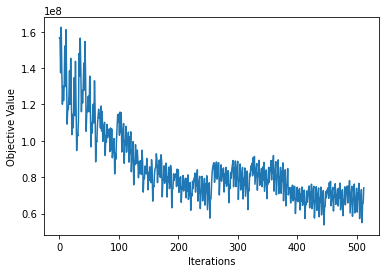

In [6]:
import matplotlib.pyplot as plt 
print('Z = ',Z)
print('====================================')
print('Y = ',Y)
print('====================================')

print('Proposed Links: ', Y[np.where(Z == np.amin(Z))[0][0]][:len(NewLinkIds)])
print('NewLinkIds      ',NewLinkIds)
plt.plot(Z)
plt.xlabel('Iterations') 
plt.ylabel('Objective Value') 
plt.show()
#plt.title('$𝑝_1$ = 2,  $𝑝_2$ <=6 and Budget=350') 
#plt.savefig("E:/paper/paper/new version/Bi-level deep learning/ver2/fig 4 node/fig4.png",dpi=200,facecolor ="w",edgecolor ='w',orientation ='landscape')